In [35]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.1f' % x)


### Playing around with using different columns that are complete

In [246]:
train = pd.read_csv('../data/clean_train_all_cols_chase.csv', parse_dates=['timestamp'], index_col="id")  
test = pd.read_csv('../data/clean_test_all_cols_chase.csv', parse_dates=['timestamp'], index_col="id")

In [247]:
bad = train[train.state.isnull() & (train.product_type=='OwnerOccupier')].copy()
bad.loc[:,'state'] = 1
bad.loc[bad.build_year>1972,'state'] = 2
bad.loc[bad.build_year>1983,'state'] = 3
bad.loc[bad.build_year>1994,'state'] = 4
train.loc[bad.index,'state'] = bad.state

In [248]:
sum(train.state.isnull())

6456

In [249]:
# get the cols that in both
tr_cols = train.columns.tolist()
te_cols = test.columns.tolist()
cols = list(set(tr_cols).intersection(te_cols))
cols.append('price_doc')

In [250]:
train_index = train.index.tolist()
test_index = test.index.tolist()

# cols = ['life_sq','full_sq','floor','max_floor','kitch_sq','product_type',
#         'sub_area','kremlin_km','price_doc','timestamp']

test['price_doc'] = np.nan

df = pd.concat([train[cols].copy(),
                test[cols].copy()],
               ignore_index=False)



# locales = pd.read_csv('../data/okurg_chase.csv')
indices = pd.read_csv('../data/district_indices.csv')
macro = pd.read_csv('../data/macro_chase.csv', parse_dates=[0])


macro['quarter'] = pd.PeriodIndex(macro['Unnamed: 0'], freq='Q').strftime('Q%q-%y')
df['month'] = df.timestamp.dt.month.astype(object)
df['quarter'] = pd.PeriodIndex(df['timestamp'], freq='Q').strftime('Q%q-%y')

# df = pd.merge(df,locales[['sub_area','okurg_district']],
#               how="left", on="sub_area").reset_index(drop=True).set_index(df.index)

df = pd.merge(df,macro[['quarter','nominal_index']],
              how="left", on="quarter").reset_index(drop=True).set_index(df.index)



# indices['month_year'] = pd.PeriodIndex(indices['date'], freq='M').strftime('%m/%y')
# df['month_year'] = pd.PeriodIndex(df['timestamp'], freq='M').strftime('%m/%y')
# indices.columns = ['id', 'okurg_district', 'month_year', 'price', 'date', 'nominal_index']

In [251]:
df.sub_area = df.sub_area.apply(lambda x: x.replace(" ", "_"))
df.sub_area = df.sub_area.apply(lambda x: x.replace("'", ""))
df.sub_area = df.sub_area.apply(lambda x: x.replace("-", ""))

In [252]:
df['kitch_to_life'] = df.kitch_sq / df.life_sq
df['life_to_full'] = df.life_sq / df.full_sq
# df['bld_type'] = 'med_rise'
# df.loc[df.max_floor <= 5,'bld_type'] = 'low_rise'
# df.loc[df.max_floor >= 17,'bld_type'] = 'high_rise'
df['floor_ratio'] = df.floor / df.max_floor
df['walk_up_penalty'] = 0
df.loc[(df.floor>4) & (df.max_floor < 6),'walk_up_penalty'] = 1 

In [253]:
df['price_doc'] = df.price_doc / df.nominal_index
df['price_full'] = df.price_doc / df.full_sq
df['log_price'] = np.log(df.price_doc+1)
# df['price_doc'] = df.price_doc / 1000


### Multiple Linear Regression

In [254]:
# print df.shape
# recent_df = df[(df.timestamp>'2013-01-01')].copy()
# print recent_df.shape
# train_index = recent_df[~recent_df.price_doc.isnull()].index.tolist()

In [306]:
target = "log_price"
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV


ols = linear_model.LinearRegression()
pipe  =  make_pipeline(MinMaxScaler(), ols)

cols = ['full_sq','floor','sub_area','kremlin_km','month','product_type','life_to_full','kitch_to_life','max_floor']

lm_data = df[cols]
df_obj = lm_data.select_dtypes(include=['object'])
df_num = lm_data.select_dtypes(exclude=['object'])


dummies = pd.get_dummies(df_obj)
df_all = pd.concat([df_num,dummies],axis=1)

x_train = df_all.loc[train_index,:]
x_test = df_all.loc[test_index,:]
y_train = df.loc[train_index,target]

ols.fit(x_train,y_train)
cross_val_score(ols, x_train, y_train, cv=5)
print('R^2: %.2f' % ols.score(x_train, y_train))
sub = np.exp(ols.predict(x_test)) - 1

R^2: 0.58


In [264]:
pd.DataFrame({'price_doc':sub},index=test_index).to_csv('../submissions/simple_linear_sq_subarea_0530_1130pm.csv')

In [268]:
ols.fit(x_train,y_train)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


array([], dtype=float64)

In [323]:
import statsmodels.formula.api as sm
from statsmodels.regression import linear_model
target = 'log_price'
cols = [target, 'full_sq','floor','max_floor','life_to_full','kitch_to_life','product_type','sub_area']

lm_data = df[cols]

df_obj = lm_data.select_dtypes(include=['object'])
df_num = lm_data.select_dtypes(exclude=['object'])

if len(df_obj) > 0:
    dummies = pd.get_dummies(df_obj)
    df_all = pd.concat([df_num,dummies],axis=1)
else:
    df_all = df_num

all_columns = "+".join(df_all.columns[1:-1])
model = sm.ols(formula =target + ' ~ ' + all_columns, data = df_all)
fitted = model.fit()
print fitted.summary()


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     265.3
Date:                Tue, 30 May 2017   Prob (F-statistic):               0.00
Time:                        23:59:56   Log-Likelihood:                -9220.6
No. Observations:               29096   AIC:                         1.874e+04
Df Residuals:                   28946   BIC:                         1.998e+04
Df Model:                         149                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

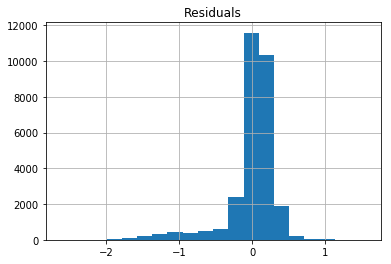

In [324]:
fig, axs = plt.subplots(figsize=(6,4))
axs.set_title('Residuals')
fitted.resid.hist(bins=20)

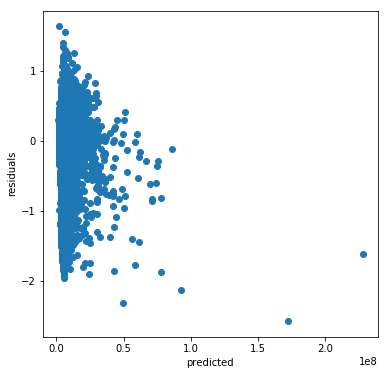

In [301]:
fig, axs = plt.subplots(figsize=(6,6))
axs.set_xlabel('predicted')
axs.set_ylabel('residuals')
plt.scatter(x=np.exp(fitted.predict(x_train)),y=fitted.resid)

In [274]:
plt.hist(fitted.norm_resid())

AttributeError: 'OLSResults' object has no attribute 'norm_resid'

In [181]:
districts = df.okurg_district.unique()

central R^2: 0.59
eastern R^2: 0.44
northeastern R^2: 0.33
northern R^2: 0.46
northwestern R^2: 0.47
outside R^2: 0.76
southeastern R^2: 0.48
southern R^2: 0.44
southwestern R^2: 0.52
western R^2: 0.55
zelenograd R^2: 0.46


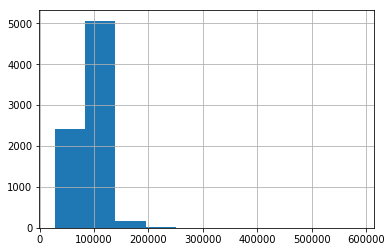

In [237]:
target = 'log_price' 
cols = [target,'full_sq','sub_area']
sub = df.loc[test_index,:].copy()
for group in df.groupby('okurg_district'):
    
    data = group[1]
    ols = linear_model.LinearRegression()
    group_train_index = data[~data.price_doc.isnull()].index
    group_test_index = data[data.price_doc.isnull()].index
    
    lm_data = data[cols]

    df_obj = lm_data.select_dtypes(include=['object'])
    df_num = lm_data.select_dtypes(exclude=['object'])

    if len(df_obj) > 0:
        dummies = pd.get_dummies(df_obj)
        df_all = pd.concat([df_num,dummies],axis=1)
    else:
        df_all = df_num

    x_train = df_all.loc[group_train_index,:].drop(target,axis=1)
    x_test = df_all.loc[group_test_index,:].drop(target,axis=1)
    y_train = df_all.loc[group_train_index,target]

    ols.fit(x_train,y_train)
    print('%s R^2: %.2f' % (group[0], ols.score(x_train, y_train)))
    if target == "log_price":
        sub.loc[group_test_index,'price_doc'] = np.exp(ols.predict(x_test)) + 1
    else:
        sub.loc[group_test_index,target] = ols.predict(x_test)

sub.price_full = sub.price_doc / sub.full_sq
sub.price_full.hist()

In [238]:

# sub.price_full = sub.price_doc / sub.full_sq

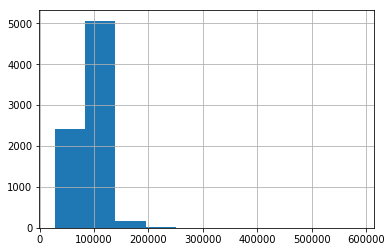

In [239]:
sub.price_full.hist()

In [240]:
df.okurg_district.unique()

array(['northeastern', 'southern', 'southeastern', 'northwestern',
       'central', 'eastern', 'northern', 'western', 'zelenograd',
       'southwestern', 'outside'], dtype=object)

In [241]:
group1 = ["central"]
group2 = ["northwestern","southwestern","western"]
group3 = ["northern","eastern","southern","northeastern","southeastern","outside"]
group4 = ["zelenograd"]

In [242]:
df['new_group'] = np.nan

In [243]:
df.loc[df.okurg_district=="central","new_group"] = "1"
df.loc[df.okurg_district.isin(group2),"new_group"] = "2"
df.loc[df.okurg_district.isin(group3),"new_group"] = "3"
df.loc[df.okurg_district.isin(group4),"new_group"] = "4"

1 R^2: 0.59
2 R^2: 0.52
3 R^2: 0.55
4 R^2: 0.46


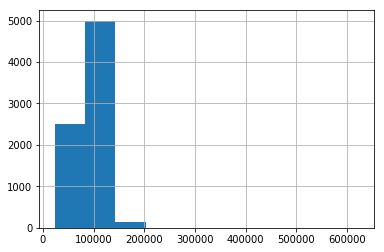

In [244]:
target = 'log_price' 
cols = [target,'full_sq','sub_area']
sub = df.loc[test_index,:].copy()
for group in df.groupby('new_group'):
    
    data = group[1]
    ols = linear_model.LinearRegression()
    group_train_index = data[~data.price_doc.isnull()].index
    group_test_index = data[data.price_doc.isnull()].index
    
    lm_data = data[cols]

    df_obj = lm_data.select_dtypes(include=['object'])
    df_num = lm_data.select_dtypes(exclude=['object'])

    if len(df_obj) > 0:
        dummies = pd.get_dummies(df_obj)
        df_all = pd.concat([df_num,dummies],axis=1)
    else:
        df_all = df_num

    x_train = df_all.loc[group_train_index,:].drop(target,axis=1)
    x_test = df_all.loc[group_test_index,:].drop(target,axis=1)
    y_train = df_all.loc[group_train_index,target]

    ols.fit(x_train,y_train)
    print('%s R^2: %.2f' % (group[0], ols.score(x_train, y_train)))
    if target == "log_price":
        sub.loc[group_test_index,'price_doc'] = np.exp(ols.predict(x_test)) - 1
    else:
        sub.loc[group_test_index,target] = ols.predict(x_test)
sub.price_full = sub.price_doc/sub.full_sq
sub.price_full.hist()

## Trying forward selection

In [188]:
from itertools import combinations

In [281]:
combos = []
for i in range(1,len(clean_df.columns.tolist())):
    combos.append(combinations(clean_df.columns.tolist(),i))

In [301]:
# get the cols that in both
# tr_cols = train.columns.tolist()
# te_cols = test.columns.tolist()
# cols = set(tr_cols).intersection(te_cols)

scores = []
df.replace([np.inf, -np.inf], np.nan,inplace=True)
clean_df = df.drop('timestamp',axis=1)
clean_df.dropna(axis=1, inplace=True)

combos = []
for i in range(2,len(clean_df.columns.tolist())):
    combos.append(combinations(clean_df.columns.tolist(),i))
    
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
pipe = make_pipeline(MinMaxScaler(),linear_model.LinearRegression())

# for c in combos:
#     for p in c:
#         lm_data = clean_df.loc[:,p]
#         df_obj = lm_data.select_dtypes(include=['object'])
#         df_num = lm_data.select_dtypes(exclude=['object'])
        
        
#         try:
#             dummies = pd.get_dummies(df_obj)
#         except:
#             pass
            
#         if len(df_obj) > 0 and len(df_num) > 0:
#             df_all = pd.concat([df_num,dummies],axis=1)

#         elif len(df_obj) < 1:
#             df_all = df_num
            
#         else:
#             df_all = df_obj
        
#         x_train = df_all.loc[train_index,:]
#         y_train = df.loc[train_index,'log_price']
#         pipe.fit(x_train,y_train)
#         scores.append(pipe.score(x_train,y_train))
    

In [ ]:
print max(scores)

In [205]:
x = ('a','b','c')

['a', 'b', 'c']

In [164]:
df.loc[test_index,'price_doc'] = np.exp(ols.predict(x_test)) * df.loc[test_index,'nominal_index']
df['price_full'] = df.price_doc / df.full_sq

In [165]:
cols = ['price_doc','full_sq','price_full']
sub = df.loc[test_index,cols]

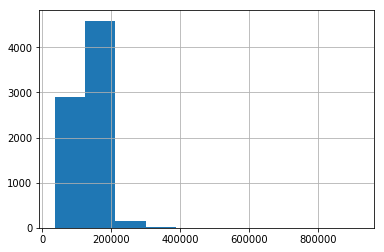

In [83]:
# kaggle score 0.33866
# sub['price_doc'].to_frame().to_csv('../Chase/submissions/simple_linear_052616.csv')

## Looking at stats

In [54]:
cols = ['price_full','product_type','life_sq','floor','kremlin_km','sub_area','month']
lm_data = df.loc[train_index,cols].copy()

df_obj = lm_data.select_dtypes(include=['object'])
df_num = lm_data.select_dtypes(exclude=['object'])

dummies = pd.get_dummies(df_obj)
df_all = pd.concat([df_num,dummies],axis=1)

In [56]:
all_columns = "+".join(df_all.columns[1:-1])
model = sm.ols(formula ='price_full ~ ' + all_columns, data = df_all)
fitted = model.fit()
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:             price_full   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     158.8
Date:                Tue, 30 May 2017   Prob (F-statistic):               0.00
Time:                        17:34:53   Log-Likelihood:            -3.4263e+05
No. Observations:               29096   AIC:                         6.856e+05
Df Residuals:                   28937   BIC:                         6.869e+05
Df Model:                         158                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

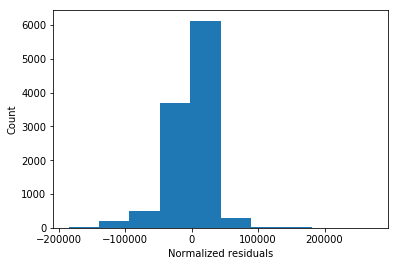

In [87]:
plt.hist(fitted.resid)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

In [307]:
influence = fitted.get_influence()
#c is the distance and p is p-value
x = pd.DataFrame({'c' :influence.cooks_distance[0], 'p': influence.cooks_distance[1]})
x.sort_values('c')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/stats/outliers_influence.py:309: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,c,p
20221,1.236036e-15,1.0
5589,1.225272e-14,1.0
13536,2.282613e-13,1.0
7994,2.571682e-13,1.0
12519,5.616858e-13,1.0
23956,6.565785e-13,1.0
9063,6.566309e-13,1.0
27791,9.269465e-13,1.0
15215,9.387580e-13,1.0
10915,1.191312e-12,1.0


In [46]:
from statsmodels.graphics.regressionplots import *
plot_leverage_resid2(fitted)
influence_plot(fitted)

NameError: name 'fitted' is not defined

In [20]:
cols = ['price_doc','full_sq','sub_area','kremlin_km','price_full']
df.loc[27096,cols]

price_doc               8439.36
full_sq                      55
sub_area      Nagatinskij_Zaton
kremlin_km              8.05738
price_full              153.443
Name: 27096, dtype: object

456.50076120743444

In [119]:
cv_scores = cross_val_score(ols, x_train, y_train, cv=10)
print cv_scores

[ 0.55611992  0.57563789  0.64236933  0.60385353  0.59513042  0.59961819
  0.57438759  0.53179857  0.6425252   0.65684506]


In [120]:
ols.predict(x_test)

array([ 15.243526  ,  15.81082405,  15.33321917, ...,  15.11978371,
        15.37032004,  15.75736919])

In [121]:
cv_scores = cross_val_score(ols, x_train, y_train, cv=10)
print cv_scores

[ 0.55611992  0.57563789  0.64236933  0.60385353  0.59513042  0.59961819
  0.57438759  0.53179857  0.6425252   0.65684506]


In [122]:
test1 = pd.DataFrame({'price_doc': ols.predict(x_test)},index=test_index)

In [123]:
test['price_doc'] = ols.predict(x_test)

In [124]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV


pipe  =  make_pipeline(MinMaxScaler(), Ridge())
param_grid = {'ridge__alpha': [100,10,1,0.1,0.01,0.001,0.0001,0]}
grid =  GridSearchCV(pipe, param_grid, cv=5)
lm_predictions = grid.fit(x_train, y_train)

In [125]:
# print lm_predictions.predict(x_train)
print lm_predictions.best_score_

0.597609856336


In [ ]:
from sklearn import preprocessing 

In [ ]:
np.exp(log_y_test)

In [58]:
cols = ['timestamp','price_doc','nominal_index','adj_price_doc','price_full','log_price','price_full']

pipe  =  make_pipeline(MinMaxScaler(), Ridge())
param_grid = {'ridge__alpha': [100,10,1,0.1,0.01,0.001,0.0001,0]}
grid =  GridSearchCV(pipe, param_grid, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [59]:
sub = grid.predict(x_test)

In [60]:
sub = pd.DataFrame({'id': test_index, 'price_doc':sub})

In [61]:
sub.loc[:,'nominal_index'] = df.loc[test_index,'nominal_index'].values

In [66]:
'%f' % 1.128899e+08

'112889900.000000'

In [62]:
sub.price_doc = sub.price_doc * sub.nominal_index

In [63]:
sub.loc[:,'price_doc'].to_frame().to_csv('../Chase/submissions/052617_linear_ridge_regression.csv')

In [126]:
# sub.sort_values('price_doc')

In [127]:
# df.loc[test_index,'nominal_index']

In [128]:
sub.head()

NameError: name 'sub' is not defined